# CPU Cycles and Degrees of Data Selectivity

## Results

Let's see the aggregated CPU cycles on both the client and the all the relavent servers in each test.

In [1]:
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
_AVG = 'avg'
_STD = 'std'

categories = ['bitrate', 'cycles', 'busyness']

def __gen_df(json_file):
    FILE_PATH = '../../backups/pyben-nio/' + json_file
    
    with open(FILE_PATH, 'r') as fobj:
        df = pd.read_json(fobj)

    for size in df.columns:
        size_df = df[size]

        for nservs in size_df.index:
            nservs_df = size_df[nservs]
            
            for cat in categories:
                client_cat = nservs_df[cat]['client']
                nservs_df[cat]['client'] = \
                    {_AVG: np.mean(client_cat), _STD: np.std(client_cat, ddof=1)}

            servers_cats = {}
            for serv_idx in range(nservs):
                for cat in categories:
                    server_cat = [arr[serv_idx] for arr in nservs_df[cat]['servers']]
                    if cat not in servers_cats:
                        servers_cats[cat] = []
                    servers_cats[cat].append(
                        {_AVG: np.mean(server_cat), _STD: np.std(server_cat, ddof=1)})                

            for cat in categories:
                nservs_df[cat]['servers'] = servers_cats[cat]

    return df

In [3]:
df = __gen_df('output_50M_iostat_1G_sys-wide_8servs/result.json')
N = len(df.columns)
ind = np.arange(N)
FIG_DPI = 120

def __plot_bars(category):
    fig, ax = plt.subplots()
    
    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(FIG_DPI)
    
    # Draw bins for category
    cat_bars = []
    
    ## Plot client section of the bar in the category
    client_cat_avgs = \
        [df[size][num_servs][category]['client']['avg'] for size in df.columns]
    client_cat_stds = \
        [df[size][num_servs][category]['client']['std'] for size in df.columns]
    
    cat_bars.append(
        ax.bar(ind,
               client_cat_avgs,
               WIDTH,
               yerr=client_cat_stds))
    last_bottom = client_cat_avgs
    
    ## Plot servers sections of the bar in the category
    for serv_idx in range(num_servs):
        server_cat_avgs = \
            [df[size][num_servs][category]['servers'][serv_idx]['avg']
             for size in df.columns]
        server_cat_stds = \
            [df[size][num_servs][category]['servers'][serv_idx]['std']
             for size in df.columns]
            
        cat_bars.append(
            ax.bar(ind,
                   server_cat_avgs,
                   WIDTH,
                   bottom=last_bottom,
                   yerr=server_cat_stds))
        last_bottom = np.sum([last_bottom, server_cat_avgs], axis=0)
    
    ax.set_ylabel(category.capitalize(), color=YAX_CLR)
    ax.tick_params('y', colors=YAX_CLR)
    ax.set_xlabel('% of the Dataset')
    
    plt.xticks(ind, df.columns)
    plt.legend(
        cat_bars,
        ['client'] + ['server ' + str(idx) for idx in df.index],
        loc=5,
        bbox_to_anchor=(-0.15, 0.5),
        frameon=False)

    return ax, cat_bars, client_cat_avgs, client_cat_stds

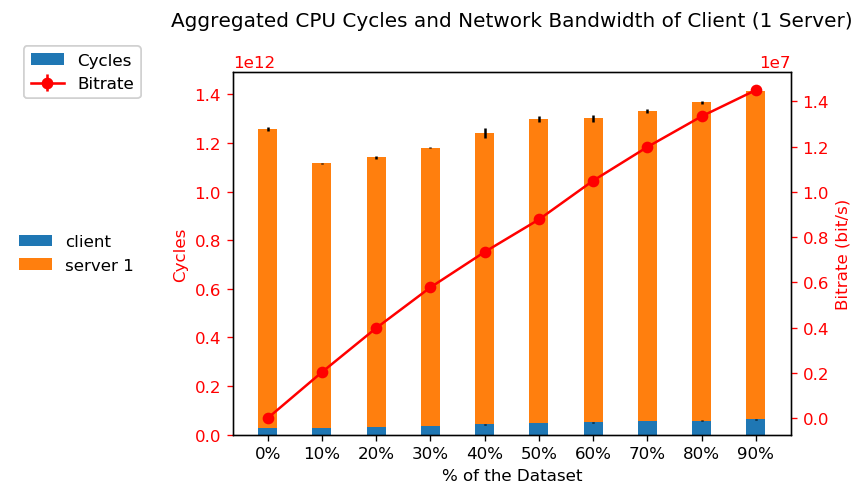

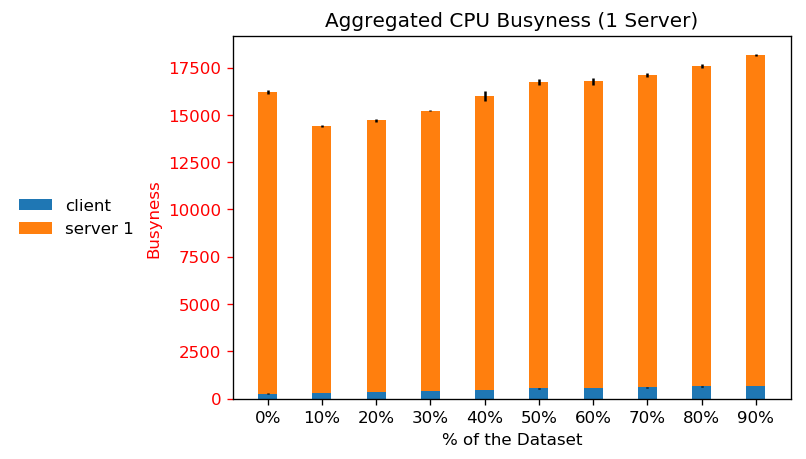

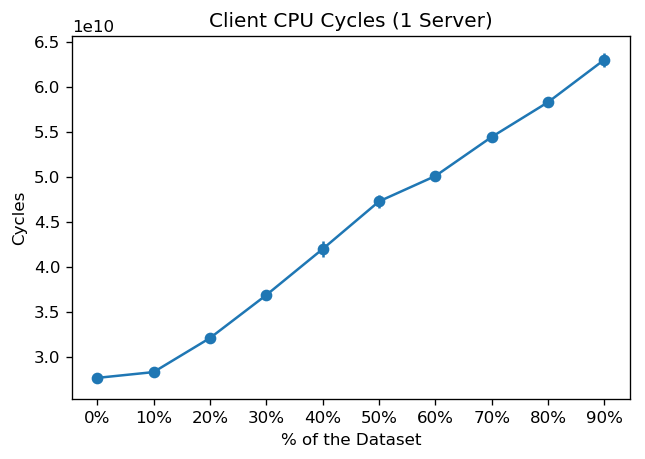

---

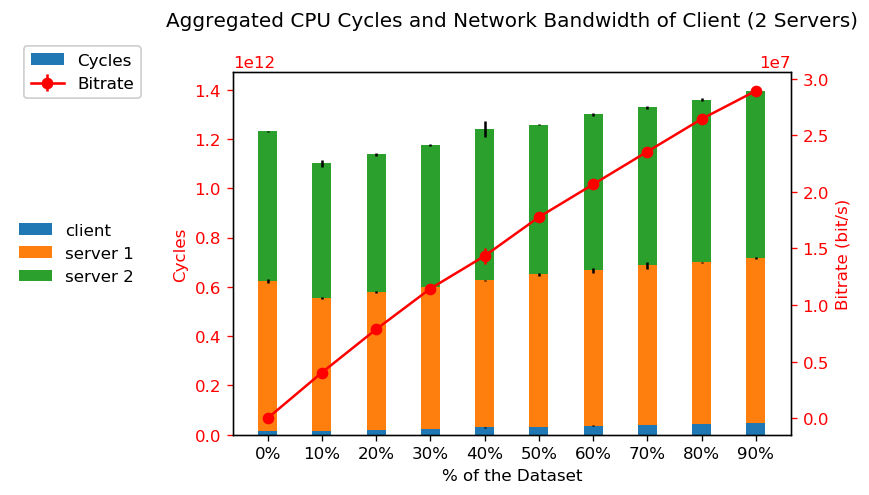

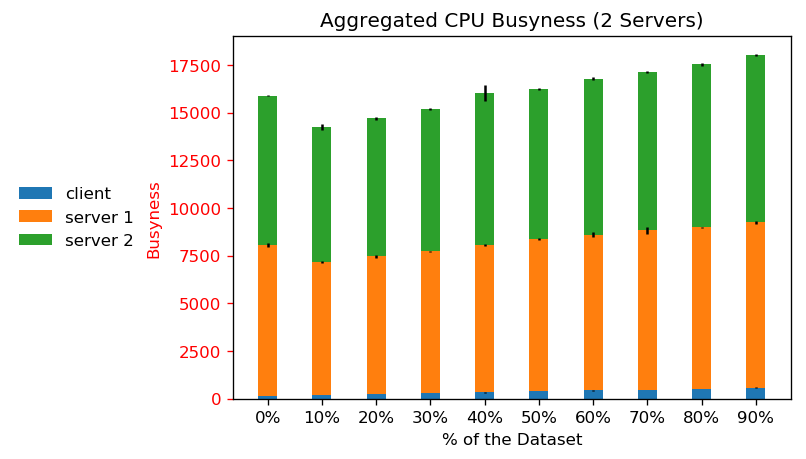

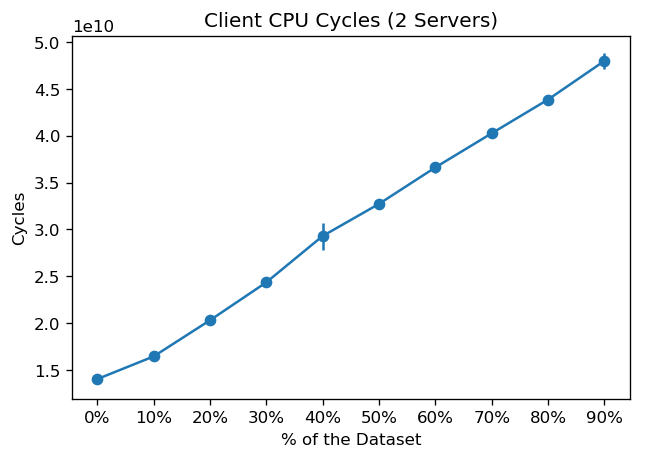

---

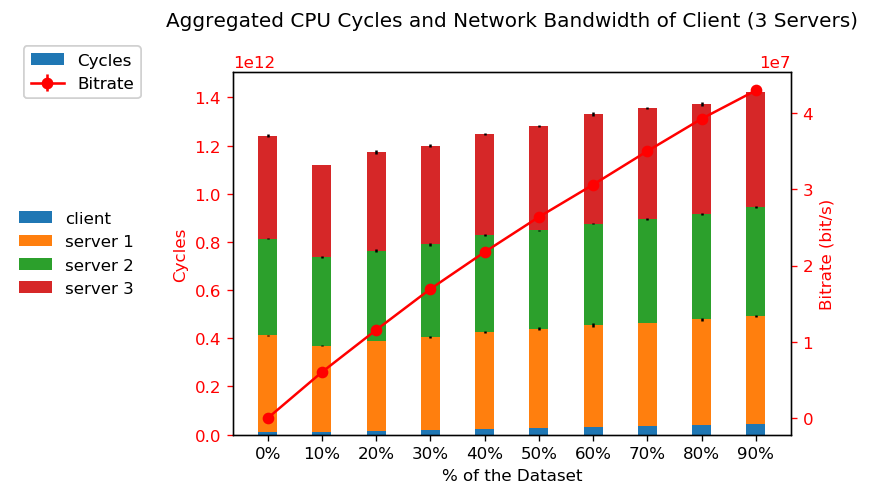

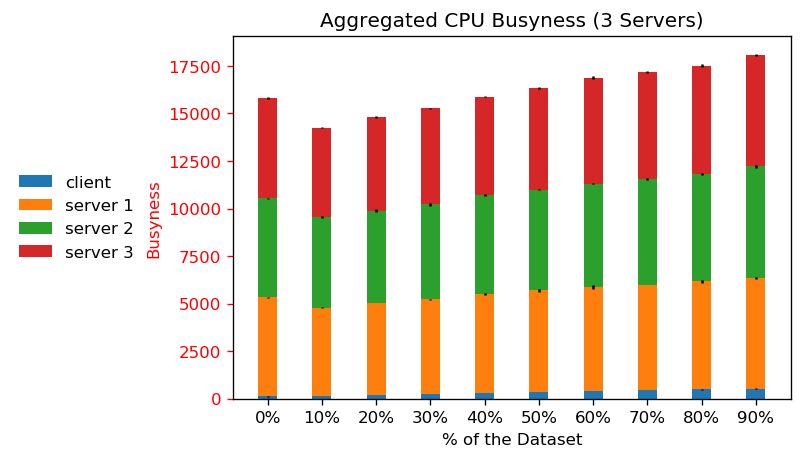

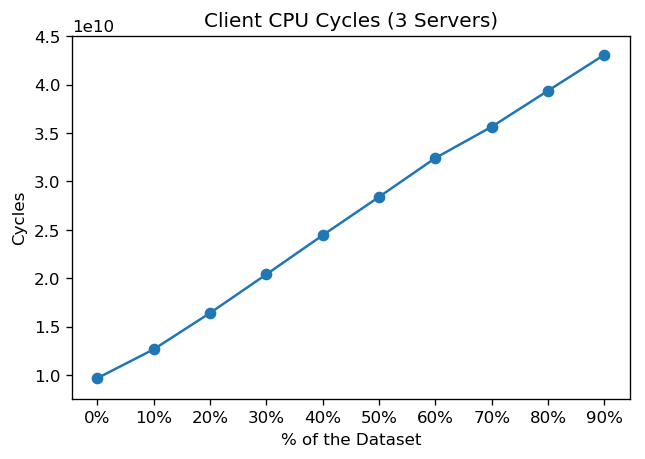

---

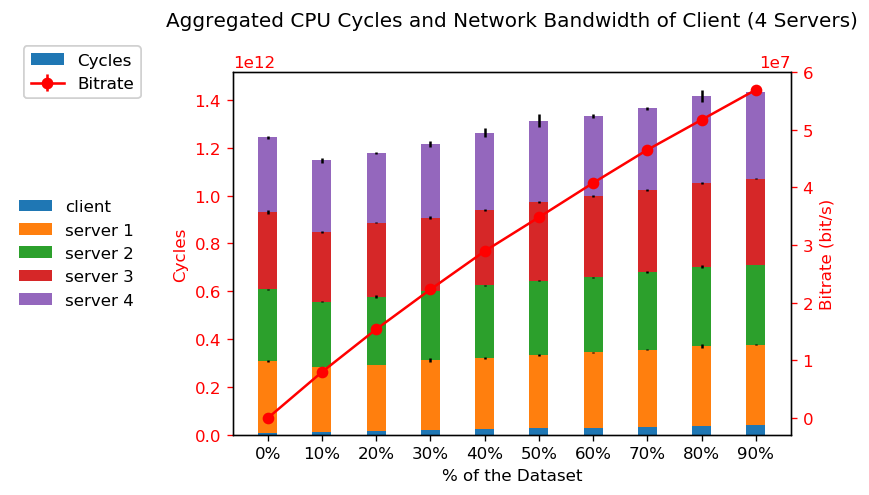

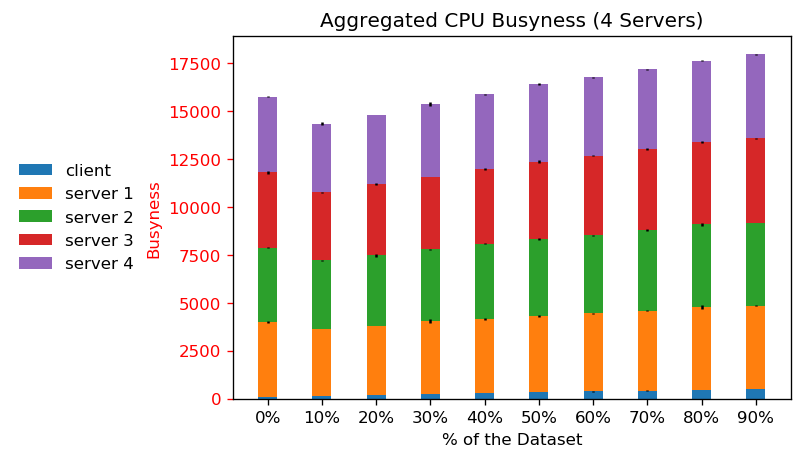

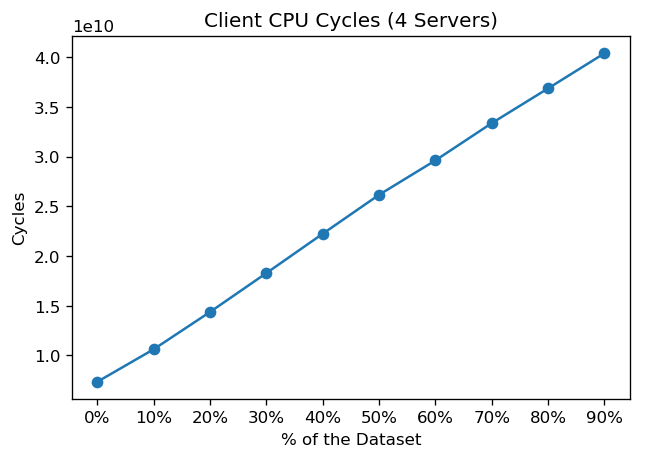

---

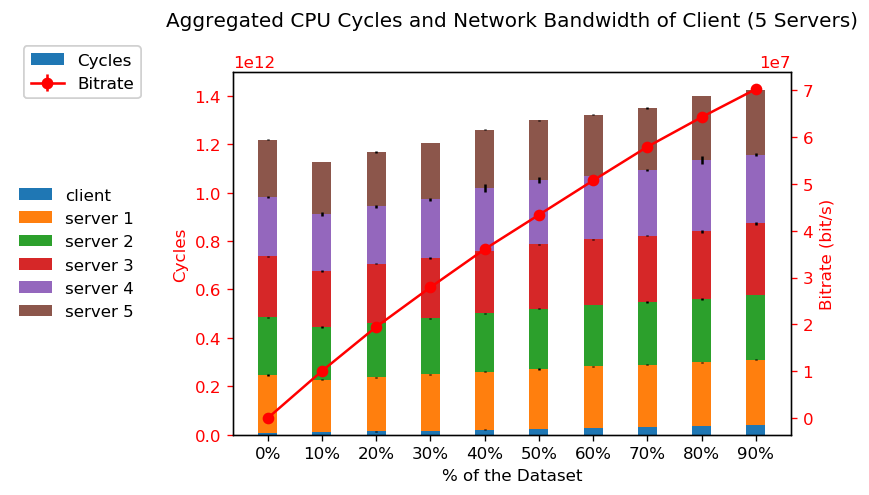

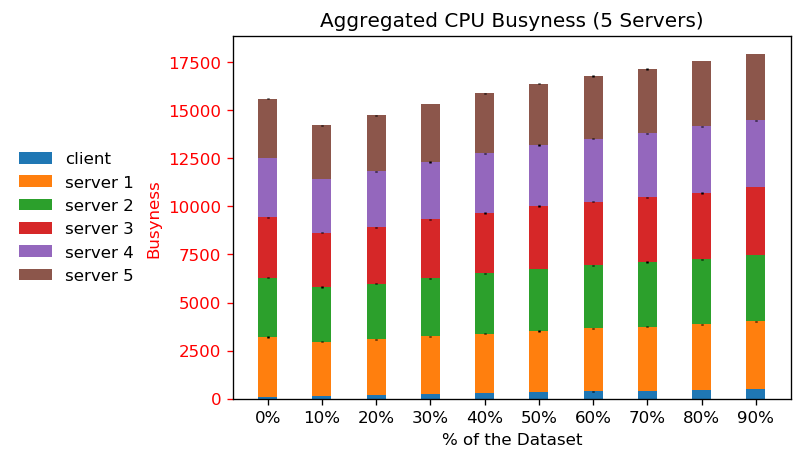

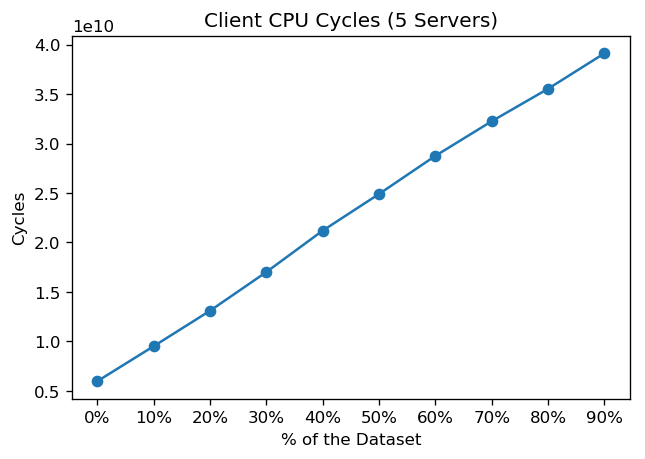

---

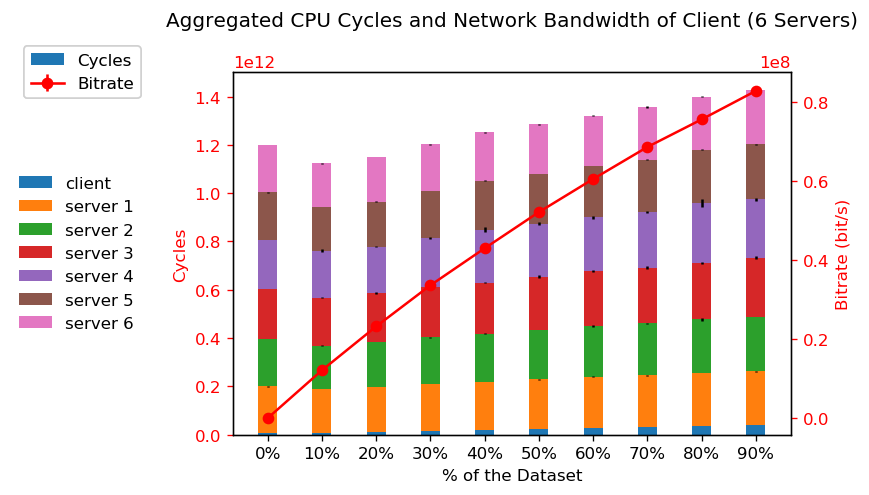

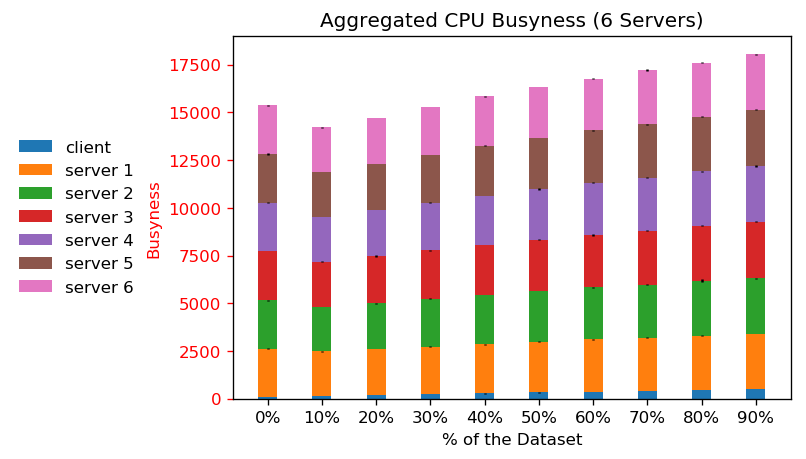

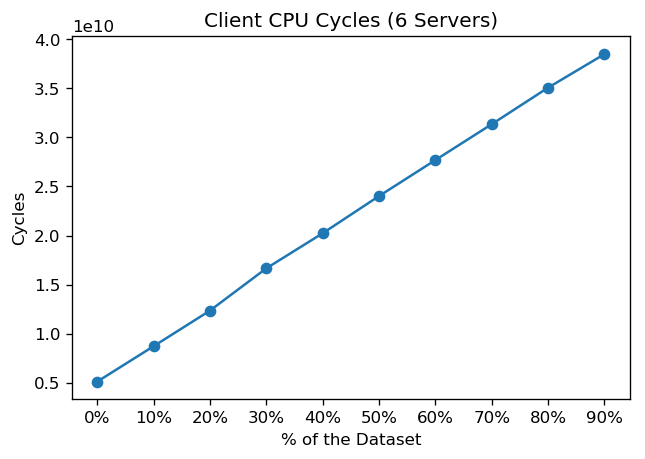

---

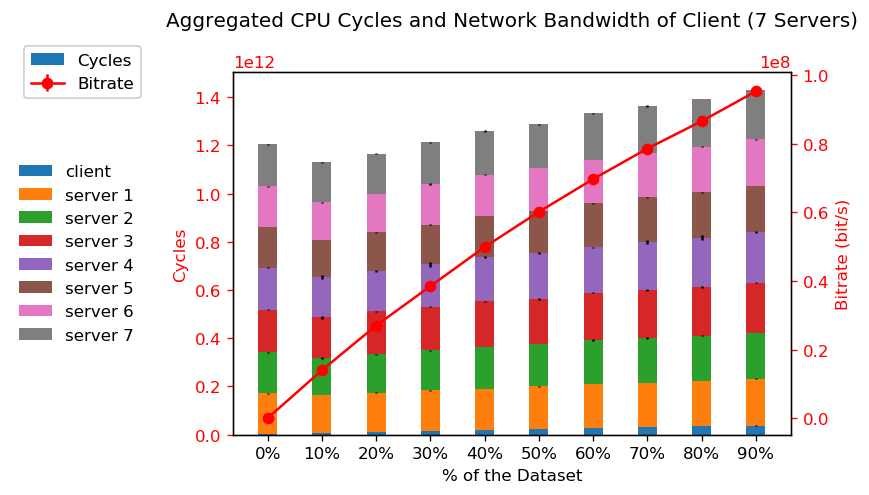

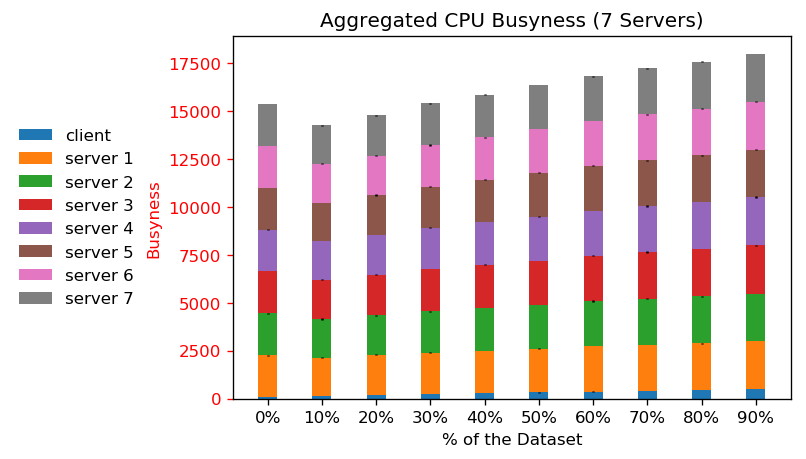

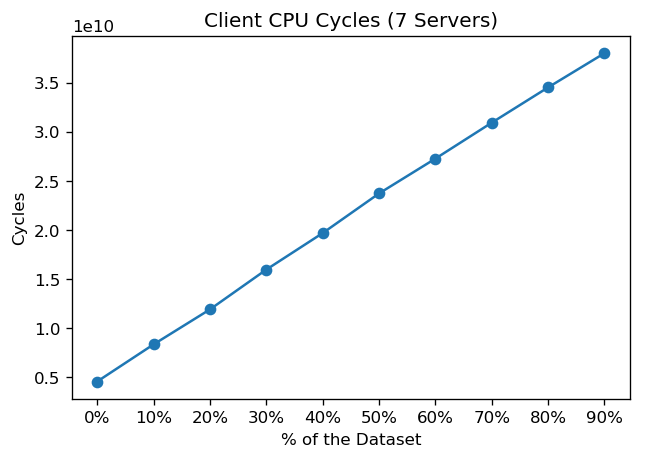

---

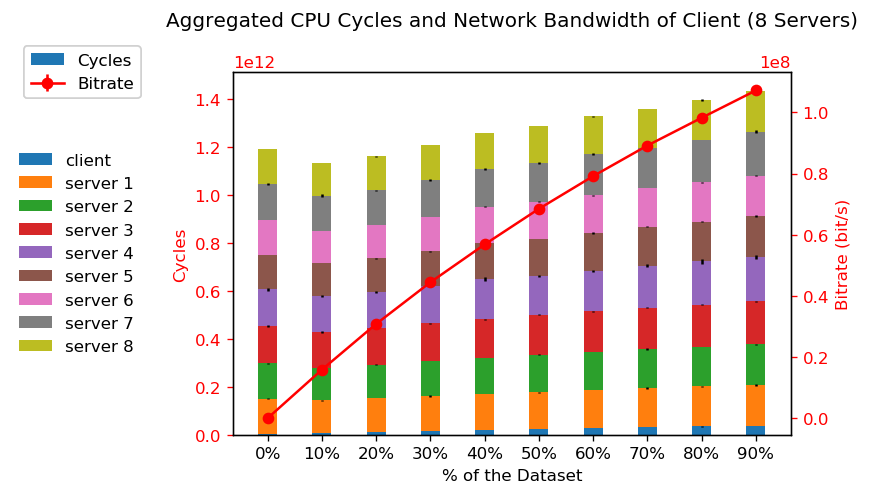

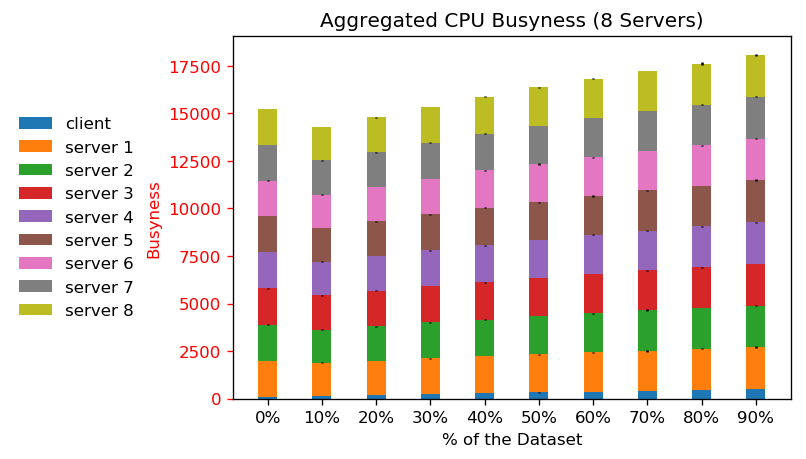

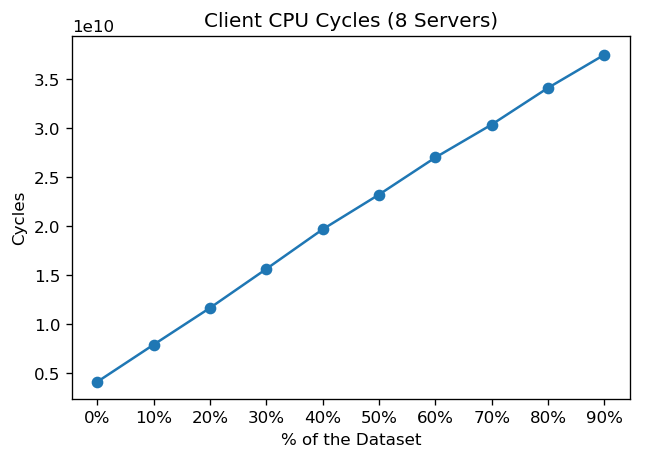

---

In [4]:
WIDTH = 0.35
YAX_CLR = 'r'

for num_servs in range(1, len(df.index) + 1):
    ax_cycles, cycle_bars, client_cycle_avgs, client_cycle_stds = __plot_bars('cycles')
    
    # Draw bitrate for client
    ax_bitrate = ax_cycles.twinx()
    
    client_bitrate_avgs = \
        [df[size][num_servs]['bitrate']['client']['avg'] for size in df.columns]
    client_bitrate_stds = \
        [df[size][num_servs]['bitrate']['client']['std'] for size in df.columns]
    
    bitrate_bar = ax_bitrate.errorbar(
        ind,
        client_bitrate_avgs,
        yerr=client_bitrate_stds,
        color=YAX_CLR,
        fmt='-o')
    
    ax_bitrate.set_ylabel('Bitrate (bit/s)', color=YAX_CLR)
    ax_bitrate.tick_params('y', colors=YAX_CLR)

    plt.gca().add_artist(plt.legend(
        [cycle_bars[0], bitrate_bar],
        ['Cycles', 'Bitrate'],
        loc=5,
        bbox_to_anchor=(-0.15, 1)))
    
    plt.title(
        'Aggregated CPU Cycles and Network Bandwidth of Client (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')', y=1.1)
    plt.show()
    
    
    # Plot the busyness bars
    ax_busyness, _, _, _ = __plot_bars('busyness')
    plt.title(
        'Aggregated CPU Busyness (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')')
    plt.show()
    
    
    # Plot the client cycles in a separated figure
    fig_client_cycles, ax_client_cycles = plt.subplots()
    fig_client_cycles.set_dpi(FIG_DPI)
    
    ax_client_cycles.errorbar(
        ind,
        client_cycle_avgs,
        yerr=client_cycle_stds,
        fmt='-o')
    
    ax_client_cycles.set_ylabel('Cycles')
    ax_client_cycles.set_xlabel('% of the Dataset')
    
    plt.xticks(ind, df.columns)
    plt.title(
        'Client CPU Cycles (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')')
    plt.show()
    
    display(Markdown('---'))

## Further Analysis

We want to use linear least-squares regression to fit the CPU cycle increasement of different number of servers.

The model we want to fit in is
```
f(x) = ax + b
```

where `f(x)` is the observed CPU cycles of running the server program, `a` is the consumption of total CPU cycles to transmit the whole dataset, `b` is rest cycles used for scanning and filtering the data which supposed to be a constant.

We use R-squared to evaluate the quality of the regression model.

---
R-squared a statistical measure of how close the data are to the fitted regression line. It is always between 0 and 100%:

- 0% indicates that the model explains none of the variability of the response data around its mean.
- 100% indicates that the model explains all the variability of the response data around its mean.

[source](http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit)

---

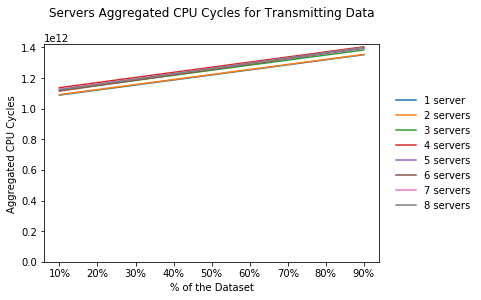

r-squareds: [0.97723446357596022, 0.98923397334056162, 0.98942243063418089, 0.99000504244378784, 0.99037020678295662, 0.99432422569348977, 0.99484146038504706, 0.9962340427234585]


In [5]:
from scipy.stats import linregress

pstgs = np.arange(0.1, 1, 0.1)

p1_args = []
r_squareds = []

for num_servs in range(1, len(df.index) + 1):
    sum_cycle_avgs = []
    for serv_idx in range(num_servs):
            server_cycle_avgs = \
                [df[size][num_servs]['cycles']['servers'][serv_idx]['avg'] for size in df.columns[1:]]
            sum_cycle_avgs = np.sum([sum_cycle_avgs, server_cycle_avgs], axis=0)

    slope, intercept, r_value, p_value, std_err = linregress(pstgs, sum_cycle_avgs)
    r_squareds.append(r_value**2)
    args = [slope, intercept]
    p1_args.append(args)
    p1 = np.poly1d(args)

    plt.plot(pstgs, p1(pstgs), '-',
             label=str(num_servs) + ' server' + ('s' if num_servs > 1 else ''))
    
plt.legend(
    loc=5,
    bbox_to_anchor=(1.3, 0.5),
    frameon=False)

plt.ylabel('Aggregated CPU Cycles')
plt.ylim(ymin=0)
plt.xlabel('% of the Dataset')
plt.xticks(pstgs, [str(int(ps * 100)) + '%' for ps in pstgs])
plt.title('Servers Aggregated CPU Cycles for Transmitting Data', y=1.1)

plt.show()

print('r-squareds: ' + repr(r_squareds))

Since for the same number of servers, the source of the difference of `Aggregated CPU Cycles` is the different size of the data transmission. We can then distill the CPU cycles consumption just for sending the data from the servers.

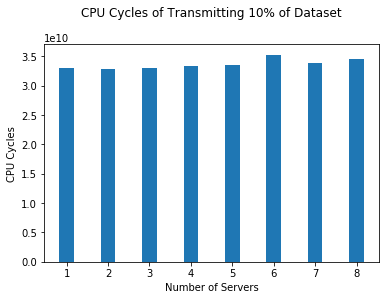

In [6]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] * 0.1 for args in p1_args], WIDTH)

ax.set_ylabel('CPU Cycles')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles of Transmitting 10% of Dataset', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

On the other hand, we can estimate how much does the cycles for transmitting the whole dataset account for the rest of work including data scaning and filtering consumed by the server program.

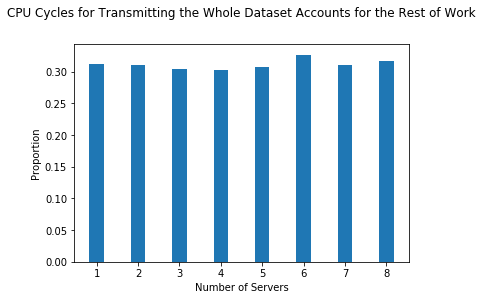

In [7]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] / args[1] for args in p1_args], WIDTH)

ax.set_ylabel('Proportion')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles for Transmitting the Whole Dataset Accounts for the Rest of Work', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

**The above figure shows we can save at most 35% of the CPU cycles consumed by the server program if we perform the data filtering right at the data source.**

We can do the same estimation for the client.

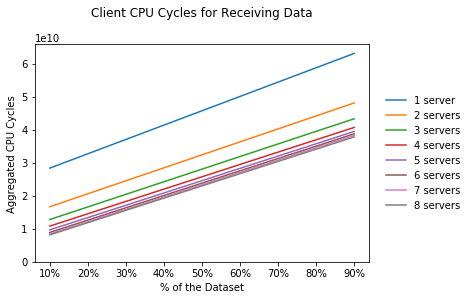

r-squareds: [0.99710690285368087, 0.99873369948647683, 0.99933944927473861, 0.99950517873138778, 0.99906220472758633, 0.99958706692109733, 0.99960542583987366, 0.99936705534414605]


In [8]:
p1_args = []
r_squareds = []

for num_servs in range(1, len(df.index) + 1):
    client_cycle_avgs = \
        [df[size][num_servs]['cycles']['client']['avg'] for size in df.columns[1:]]
    
    slope, intercept, r_value, p_value, std_err = linregress(pstgs, client_cycle_avgs)
    r_squareds.append(r_value**2)
    args = [slope, intercept]
    p1_args.append(args)
    p1 = np.poly1d(args)

    plt.plot(pstgs, p1(pstgs), '-',
             label=str(num_servs) + ' server' + ('s' if num_servs > 1 else ''))

plt.legend(
    loc=5,
    bbox_to_anchor=(1.3, 0.5),
    frameon=False)

plt.ylabel('Aggregated CPU Cycles')
plt.ylim(ymin=0)
plt.xlabel('% of the Dataset')
plt.xticks(pstgs, [str(int(ps * 100)) + '%' for ps in pstgs])
plt.title('Client CPU Cycles for Receiving Data', y=1.1)

plt.show()

print('r-squareds: ' + repr(r_squareds))

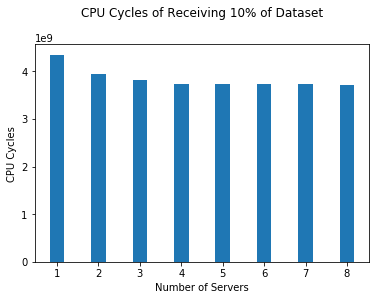

In [9]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] * 0.1 for args in p1_args], WIDTH)

ax.set_ylabel('CPU Cycles')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles of Receiving 10% of Dataset', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

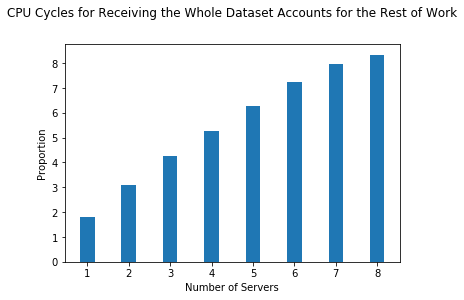

In [10]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] / args[1] for args in p1_args], WIDTH)

ax.set_ylabel('Proportion')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles for Receiving the Whole Dataset Accounts for the Rest of Work', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

The above figure makes sense because we assume the client program would use most of the time/resources just for receiving the date.